

1.   Import Package
2.   Data Cleaning and processing
3.   Word Embedding (Glove)
2.   Implemented LSTM
2.   Implement BiLSTM


In [ ]:
#install libraries
!pip install bnlp
!pip install bnlp_toolkit
!pip install --upgrade bnlp_toolkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached fasttext-0.9.2.tar.gz (68 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4393381 sha256=dc72dcd9301e9728e015d0eb4c0d1c44c38febd4263032172a91a5658e53656a
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
#import libraries
import numpy as np
import pandas as pd
import random
import re, string
import seaborn as sns
import matplotlib.pyplot as plt

from string import punctuation
from bnlp import BasicTokenizer
from bnlp import NLTKTokenizer
from bnlp import SentencepieceTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits
from bnlp.corpus.util import remove_stopwords
from bnlp import BengaliWord2Vec

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

#Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


#PyTorch LSTM
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

import gensim
from gensim.models import Word2Vec, FastText
import fasttext
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

<ipython-input-8-7d5d335e6a9c>:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

## Define Performance Metrics & Confusion Matrix

In [ ]:
# Calculate performance metrics
def perf_matrix(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  f1 = f1_score(y_test, y_pred, average='weighted')

  print('Accuracy:', accuracy)
  print('Precision:', precision)
  print('Recall:', recall)
  print('F1 Score:', f1)

# Plot confusion matrix
def conf_matrix(y_test, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(4,4))
    ax=sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Greens", fmt='g', cbar=True, annot_kws={"size":20})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16)
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
%cd drive/MyDrive/Colab Notebooks/Thesis Project/

In [ ]:
!ls


# Word Embedding (Glove)

In [ ]:
# Load the dataset
df = pd.read_excel('1. Depression Analysis Dataset Cleaned v2.xlsx')

# Train-Validation-Test Split
df = df.sample(frac=1)

X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

# Data Preprocessing
def Tokenize(column, seq_len):
    # Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    # Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)

    # Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

MAX_LEN = 5000

vocabulary, tokenized_column = Tokenize(df["text"], MAX_LEN)

# Load GloVe embeddings
glove_vectors = 'bn_glove.300d.txt'

# Word Embedding by Glove

EMBEDDING_DIM = 100

VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding
VOCAB_SIZE

#define empty embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

#fill the embedding matrix with the pre trained values from Glove
#corresponding to word (string), token (number associated to the word)
for word, token in vocabulary:
    if word in glove_vectors:
        embedding_matrix[token] = glove_vectors[word]


print("Embedding Matrix Shape:", embedding_matrix.shape)

# Train - Validation - Test split

X = tokenized_column
y = df['label'].values
y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

# Data preprocessing for LSTM

In [ ]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [ ]:
max_len = 5000

In [ ]:
vocabulary, tokenized_column = Tokenize(df["text"], max_len)

In [ ]:
vocabulary[:20]

In [ ]:
tokenized_column[3:6]

In [ ]:
df["text"].iloc[10]

In [ ]:
tokenized_column[10]

## Train - Validation - Test split

In [ ]:
df.head(10)

In [ ]:
X = tokenized_column
y = df['label'].values
y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

In [ ]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

# PyTorch datasets and dataloaders

In [ ]:
torch.cuda.empty_cache()

In [ ]:
BATCH_SIZE = 8
EPOCHS = 20 #Number of training epoch
LR = 0.001 #Learning rate
DROPOUT = 0.2 #LSTM Dropout
WEIGHT_DECAY = 0.01
LSTM_LAYERS = 3 #Number of stacked LSTM layers
HIDDEN_DIM = 64 #number of neurons of the internal state (internal neural network in the LSTM)

NUM_CLASSES = 2 #We are dealing with a multiclass classification of 2 classes
BIDIRECTIONAL = False #Boolean value to choose if to use a bidirectional LSTM or not

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [ ]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

## PyTorch LSTM modeling

In [ ]:
class LSTM_Sentiment_Classifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, bidirectional,batch_size, dropout):
        super(LSTM_Sentiment_Classifier,self).__init__()

        self.lstm_layers = lstm_layers
        self.num_directions = 2 if bidirectional else 1
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.batch_size = batch_size


        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=lstm_layers,
                            dropout=dropout,
                            bidirectional=bidirectional,
                            batch_first=True)

        self.fc = nn.Linear(hidden_dim*self.num_directions, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        self.batch_size = x.size(0)
        ##EMBEDDING LAYER
        embedded = self.embedding(x)
        #LSTM LAYERS
        out, hidden = self.lstm(embedded, hidden)
        #Extract only the hidden state from the last LSTM cell
        out = out[:,-1,:]
        #FULLY CONNECTED LAYERS
        out = self.fc(out)
        out = self.softmax(out)

        return out, hidden

    def init_hidden(self, batch_size):
        #Initialization of the LSTM hidden and cell states
        h0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        c0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        hidden = (h0, c0)
        return hidden

In [ ]:
model = LSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM,NUM_CLASSES, LSTM_LAYERS,BIDIRECTIONAL, BATCH_SIZE, DROPOUT)
model = model.to(DEVICE)

#Initialize embedding with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
#Allow the embedding matrix to be fined tuned to better adapt to out dataset and get higher accuracy
model.embedding.weight.requires_grad=True

print(model)

LSTM_Sentiment_Classifier(
  (embedding): Embedding(63367, 100)
  (lstm): LSTM(100, 64, num_layers=3, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=64, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [ ]:
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = WEIGHT_DECAY)

### LSTM Training loop

In [ ]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients

        output, h = model(inputs,h) #get output and hidden states from LSTM network

        loss = criterion(output, labels)
        loss.backward()

        running_loss += loss.item()

        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list

        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####

    with torch.no_grad():

        model.eval()

        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase

    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break

    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

Epoch 1:Validation accuracy increased (0.000000 --> 86.731844).  Saving model ...
	Train_loss : 0.4063 Val_loss : 0.3138
	Train_acc : 82.245% Val_acc : 86.732%
Epoch 2:Validation accuracy increased (86.731844 --> 86.801676).  Saving model ...
	Train_loss : 0.1936 Val_loss : 0.3438
	Train_acc : 92.933% Val_acc : 86.802%
Epoch 3:Validation accuracy increased (86.801676 --> 87.988827).  Saving model ...
	Train_loss : 0.1095 Val_loss : 0.3710
	Train_acc : 96.238% Val_acc : 87.989%
Epoch 4:Validation accuracy did not increase
	Train_loss : 0.0631 Val_loss : 0.5222
	Train_acc : 97.724% Val_acc : 84.148%
Epoch 5:Validation accuracy did not increase
	Train_loss : 0.0392 Val_loss : 0.5436
	Train_acc : 98.839% Val_acc : 86.383%
Epoch 6:Validation accuracy did not increase
	Train_loss : 0.0289 Val_loss : 0.6069
	Train_acc : 99.087% Val_acc : 85.475%
Epoch 7:Validation accuracy did not increase
	Train_loss : 0.0184 Val_loss : 0.7432
	Train_acc : 99.303% Val_acc : 84.148%
Epoch 8:Validation accurac

In [ ]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

### LSTM Testing

In [ ]:
model.eval()
y_pred_list = []
y_test_list = []
for inputs, labels in test_loader:
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    test_h = model.init_hidden(labels.size(0))

    output, val_h = model(inputs, test_h)
    y_pred_test = torch.argmax(output, dim=1)
    y_pred_list.extend(y_pred_test.squeeze().tolist())
    y_test_list.extend(labels.squeeze().tolist())

In [ ]:
label = ['0', '1']

In [ ]:
print('Classification Report for LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=label))

Classification Report for LSTM :
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      1792
           1       0.86      0.88      0.87      1792

    accuracy                           0.87      3584
   macro avg       0.87      0.87      0.87      3584
weighted avg       0.87      0.87      0.87      3584



Accuracy: 0.8708147321428571
Precision: 0.8709257350474395
Recall: 0.8708147321428571
F1 Score: 0.8708050664527162


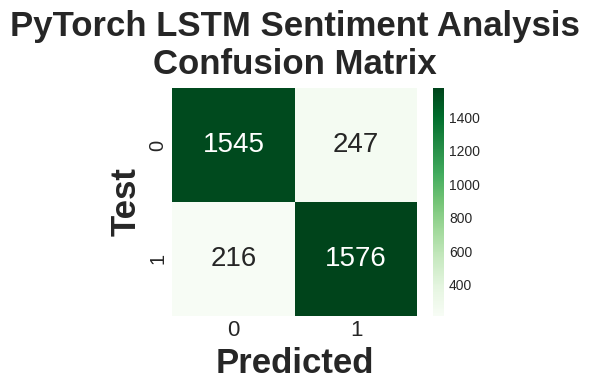

In [ ]:
perf_matrix(y_test_list, y_pred_list)
conf_matrix(y_test_list,y_pred_list,'PyTorch LSTM Sentiment Analysis\nConfusion Matrix', label)

## PyTorch BiLSTM modeling

In [ ]:
NUM_CLASSES = 2 #We are dealing with a multiclass classification of 2 classes
BIDIRECTIONAL = True #Boolean value to choose if to use a bidirectional LSTM or not

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class BiLSTM_Sentiment_Classifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, bidirectional,batch_size, dropout):
        super(BiLSTM_Sentiment_Classifier,self).__init__()

        self.lstm_layers = lstm_layers
        self.num_directions = 2 if bidirectional else 1
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.batch_size = batch_size


        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=lstm_layers,
                            dropout=dropout,
                            bidirectional=bidirectional,
                            batch_first=True)

        self.fc = nn.Linear(hidden_dim*self.num_directions, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        self.batch_size = x.size(0)
        ##EMBEDDING LAYER
        embedded = self.embedding(x)
        #LSTM LAYERS
        out, hidden = self.lstm(embedded, hidden)
        #Extract only the hidden state from the last LSTM cell
        out = out[:,-1,:]
        #FULLY CONNECTED LAYERS
        out = self.fc(out)
        out = self.softmax(out)

        return out, hidden

    def init_hidden(self, batch_size):
        #Initialization of the LSTM hidden and cell states
        h0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        c0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        hidden = (h0, c0)
        return hidden

In [ ]:
model = BiLSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM,NUM_CLASSES, LSTM_LAYERS,BIDIRECTIONAL, BATCH_SIZE, DROPOUT)
model = model.to(DEVICE)

#Initialize embedding with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
#Allow the embedding matrix to be fined tuned to better adapt to out dataset and get higher accuracy
model.embedding.weight.requires_grad=True

print(model)

BiLSTM_Sentiment_Classifier(
  (embedding): Embedding(63367, 100)
  (lstm): LSTM(100, 64, num_layers=3, batch_first=True, dropout=0.1, bidirectional=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [ ]:
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = WEIGHT_DECAY)

### BiLSTM Training loop

In [ ]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients

        output, h = model(inputs,h) #get output and hidden states from LSTM network

        loss = criterion(output, labels)
        loss.backward()

        running_loss += loss.item()

        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list

        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####

    with torch.no_grad():

        model.eval()

        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase

    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break

    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

Epoch 1:Validation accuracy increased (0.000000 --> 88.268156).  Saving model ...
	Train_loss : 0.4016 Val_loss : 0.3102
	Train_acc : 82.276% Val_acc : 88.268%
Epoch 2:Validation accuracy did not increase
	Train_loss : 0.1905 Val_loss : 0.4116
	Train_acc : 93.042% Val_acc : 82.402%
Epoch 3:Validation accuracy did not increase
	Train_loss : 0.1106 Val_loss : 0.4135
	Train_acc : 96.331% Val_acc : 86.732%
Epoch 4:Validation accuracy did not increase
	Train_loss : 0.0685 Val_loss : 0.4246
	Train_acc : 97.786% Val_acc : 85.545%
Epoch 5:Validation accuracy did not increase
	Train_loss : 0.0443 Val_loss : 0.4442
	Train_acc : 98.514% Val_acc : 86.103%
Epoch 6:Validation accuracy did not increase
Early stopped at epoch : 6


In [ ]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

### BiLSTM Testing

In [ ]:
model.eval()
y_pred_list = []
y_test_list = []
for inputs, labels in test_loader:
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    test_h = model.init_hidden(labels.size(0))

    output, val_h = model(inputs, test_h)
    y_pred_test = torch.argmax(output, dim=1)
    y_pred_list.extend(y_pred_test.squeeze().tolist())
    y_test_list.extend(labels.squeeze().tolist())

In [ ]:
label = ['0','1']

In [ ]:
print('Classification Report for Bi-LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=label))

Classification Report for Bi-LSTM :
               precision    recall  f1-score   support

           0       0.87      0.88      0.88      1792
           1       0.88      0.87      0.87      1792

    accuracy                           0.87      3584
   macro avg       0.87      0.87      0.87      3584
weighted avg       0.87      0.87      0.87      3584



Accuracy: 0.8747209821428571
Precision: 0.8747827210903422
Recall: 0.8747209821428571
F1 Score: 0.874715822544497


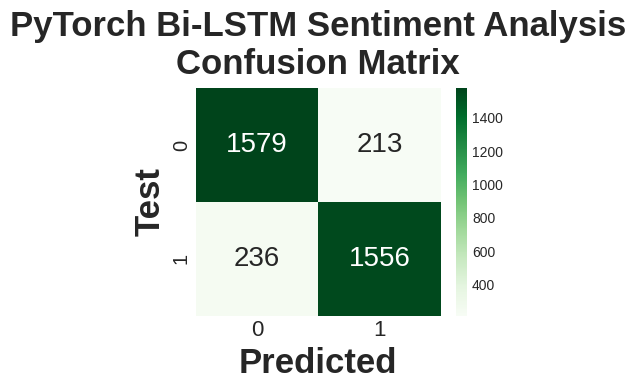

In [ ]:
perf_matrix(y_test_list, y_pred_list)
conf_matrix(y_test_list,y_pred_list,'PyTorch Bi-LSTM Sentiment Analysis\nConfusion Matrix', label)